In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import StandardScaler

## Importing the data

In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")
dataLands

dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")

dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")

## Cleaning

- Removing NAN
- Removing useless columns

In [3]:
dataLands = dataLands.dropna(subset=["element"])

dataCrops = dataCrops.dropna(subset=["element"])

dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})

## Creating the dataset for processing

In [4]:
cropsAndEmissions = dataCrops.drop(["element_code"], axis=1)\
                                .where(dataCrops["element"] == "Area Harvested")\
                                .dropna(subset=["element"])\
                                .drop(["element", "value_footnotes"],axis=1)\
                                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions = cropsAndEmissions.pivot_table(values='Value area',index=["Area","Year"],columns="category").reset_index()
cropsAndEmissions = cropsAndEmissions.fillna(0)
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])
cropsAndEmissions

,Area,Year,agave_fibres_nes,almonds_with_shell,anise_badian_fennel_corian,apples,apricots,arecanuts,artichokes,asparagus,...,vegetables_melons_total,vetches,walnuts_with_shell,watermelons,wheat,yams,yautia_cocoyam,Area Code,Unit emissions,Value emissions
29,Afghanistan,1990.0,0.0,5400.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,54600.0,0.0,2300.0,8200.0,1570000.0,0.0,0.0,2.0,Gigagrams,7342.7099
30,Afghanistan,1991.0,0.0,5500.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,52500.0,0.0,2300.0,7800.0,1690000.0,0.0,0.0,2.0,Gigagrams,7631.0272
31,Afghanistan,1992.0,0.0,5500.0,700.0,2340.0,5060.0,0.0,0.0,0.0,...,52900.0,0.0,2300.0,7800.0,1600000.0,0.0,0.0,2.0,Gigagrams,7631.4427
32,Afghanistan,1993.0,0.0,5500.0,700.0,2300.0,5100.0,0.0,0.0,0.0,...,54900.0,0.0,2300.0,7800.0,1900000.0,0.0,0.0,2.0,Gigagrams,7702.7416
33,Afghanistan,1994.0,0.0,5500.0,700.0,2350.0,5100.0,0.0,0.0,0.0,...,56900.0,0.0,2300.0,7800.0,2000000.0,0.0,0.0,2.0,Gigagrams,7699.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,Zimbabwe,2003.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,25937.0,0.0,0.0,0.0,26500.0,0.0,0.0,181.0,Gigagrams,9779.6837
10728,Zimbabwe,2004.0,0.0,0.0,200.0,750.0,20.0,0.0,17.0,60.0,...,26092.0,0.0,0.0,0.0,26300.0,0.0,0.0,181.0,Gigagrams,10470.7635
10729,Zimbabwe,2005.0,0.0,0.0,200.0,900.0,20.0,0.0,17.0,60.0,...,26242.0,0.0,0.0,0.0,28000.0,0.0,0.0,181.0,Gigagrams,9877.5998
10730,Zimbabwe,2006.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,23502.0,0.0,0.0,0.0,35000.0,0.0,0.0,181.0,Gigagrams,10053.3116


## Learning to predict emissions

Best alpha is 30.645161290322577 with a MSE of 385830822.5067357 .


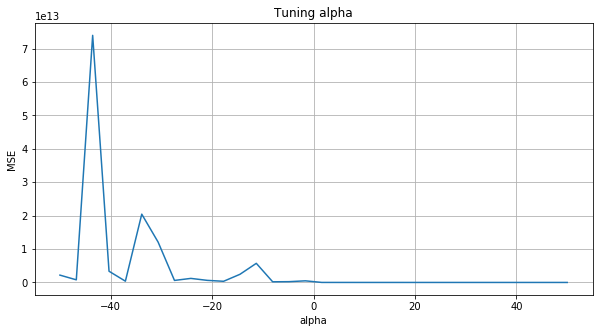

In [6]:
SEED = 1
st_pipeline = Pipeline([('scl', StandardScaler()), ('ridge', Ridge(copy_X=True, random_state=SEED))])
st_pipeline

#features = ["Area","category"]

XRidge2 = pd.get_dummies(cropsAndEmissions.drop(["Area Code","Unit emissions", "Value emissions"], axis=1))
yRidge2 = cropsAndEmissions["Value emissions"]

results = []

# Tune for alpha using 10 fold crossvalidation when calculating the mean squared error.
for alpha in np.linspace(-100, 100, 128):
    st_pipeline.set_params(ridge__alpha= alpha) 
    neg_MSE = cross_val_score(st_pipeline, XRidge2, yRidge2, scoring='neg_mean_squared_error', cv=10)  # we use 10 folds crossvalidation since 10 
                                                                                                      # is pretty much standard in the industry
    results.append([neg_MSE, alpha])
    
# Take the mean MSE for each level of alpha
for i in range(len(results)):
    results[i][0] = -np.mean(results[i][0])
    
# Plot the results
plt.figure(figsize=(10,5))
plt.plot([row[1] for row in results], [row[0] for row in results])
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Tuning alpha');
plt.grid()

best_st_alpha = min(results)[1]
print('Best alpha is', best_st_alpha, 'with a MSE of', min(results)[0],'.')

In [7]:
st_Model = st_pipeline.set_params(ridge__alpha= best_st_alpha)  # use best alpha calculated above
st_Model.fit(XRidge2, yRidge2)                                  # fit the new model

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=30.645161290322577, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=1, solver='auto', tol=0.001))],
         verbose=False)

In [8]:
#st_Model.named_steps["ridge"].coef_
pd.DataFrame([XRidge2.columns,st_Model.named_steps["ridge"].coef_]).transpose().sort_values(1)

,0,1
91,mushrooms_and_truffles,-2096.98
107,other_melons_inc_cantaloupes,-2058.74
356,Area_Ukraine,-1594.71
301,Area_Nigeria,-1484.43
216,Area_Cuba,-1470.97
...,...,...
195,Area_Brazil,3859.46
143,soybeans,3948.64
83,maize,4510.29
179,Area_Australia,6023.01
